In [10]:
# run source activate.sh in terminal for venv

# windows: 
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass
# .\venv\Scripts\activate


from astropy.io import fits
import numpy as np 
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture

# change dir to dataset directory
# os.chdir('/Users/kevchen/Desktop/UNI/THESIS B/starlink_dataset')
# windows
os.chdir(r'C:\Users\Kevin Chen\Desktop\Uni\Thesis\Thesis-B-Telescope-Imaging\starlink_dataset')


fits_files = []

sorted_files = sorted([f for f in os.listdir(os.getcwd())])

# append all fits filenames to fits_files
for filename in sorted_files:
    fits_files.append(filename)

print(fits_files)

sample_index = fits_files.index('20201220013721092_45696.fit')

print(sample_index)

['20201220013535730_45696.fit', '20201220013540337_45696.fit', '20201220013544922_45696.fit', '20201220013549531_45696.fit', '20201220013554167_45696.fit', '20201220013558844_45696.fit', '20201220013603459_45696.fit', '20201220013608069_45696.fit', '20201220013612738_45696.fit', '20201220013617365_45696.fit', '20201220013621893_45696.fit', '20201220013626441_45696.fit', '20201220013630975_45696.fit', '20201220013635515_45696.fit', '20201220013640166_45696.fit', '20201220013644714_45696.fit', '20201220013649254_45696.fit', '20201220013653780_45696.fit', '20201220013658328_45696.fit', '20201220013702868_45696.fit', '20201220013707426_45696.fit', '20201220013711959_45696.fit', '20201220013716487_45696.fit', '20201220013721092_45696.fit', '20201220013725629_45696.fit', '20201220013730154_45696.fit', '20201220013734730_45696.fit', '20201220013739273_45696.fit', '20201220013743802_45696.fit', '20201220013748345_45696.fit', '20201220013752938_45696.fit', '20201220013757532_45696.fit', '202012

In [11]:
sample_filename = fits_files[sample_index]

file = fits.open(sample_filename)

header_data = file[0].header

print(header_data.tostring(sep='\n'))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
TIMESYS = 'UTC     '           / default time system                            
DATE-OBS= '2020-12-20T01:37:21.092000' / exposure start epoch UTC               
MJD-OBS =    59203.067605231

In [12]:
fits_data = []

# open all fits files, append the image data for each one onto fits_data
for fits_file in fits_files:
    file_data = fits.open(fits_file)
    image_data = file_data[0].data
    header = file_data[0].header

    fits_data.append(image_data)

# print(fits_data)

sample_file = fits_data[sample_index]

# print everything // not good for github, commented out for now
np.set_printoptions(threshold=np.inf)
# print(sample_file)

963
14879


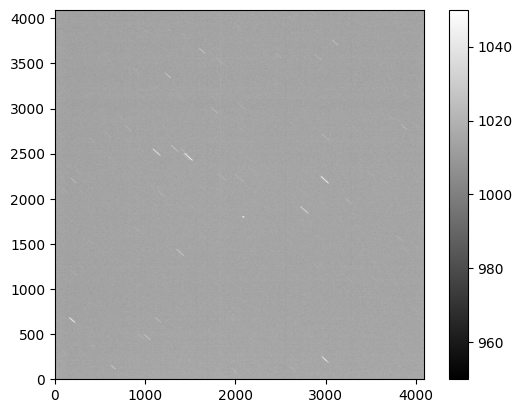

In [13]:
min_val = np.min(sample_file)
max_val = np.max(sample_file)

print(min_val)
print(max_val)

plt.figure()
# log scaling for high contrast
# plt.imshow(sample_file, origin = 'lower', norm = LogNorm(vmin=min_val, vmax=max_val), cmap='gray')

# linear scaling for low contrast
plt.imshow(sample_file, origin = 'lower', vmin = 950, vmax=1050, cmap='gray')
plt.colorbar()
plt.show()

# plotting all images to check if they're all in satellite tracking mode - stars shown as streaks
# for image_data in fits_data:
#     plt.figure()
#     # log scaling for high contrast
#     # plt.imshow(sample_file, origin = 'lower', norm = LogNorm(vmin=min_val, vmax=max_val), cmap='gray')

#     # linear scaling for low contrast
#     plt.imshow(image_data, origin = 'lower', vmin = 950, vmax=1050, cmap='gray')
#     plt.colorbar()
#     plt.show()

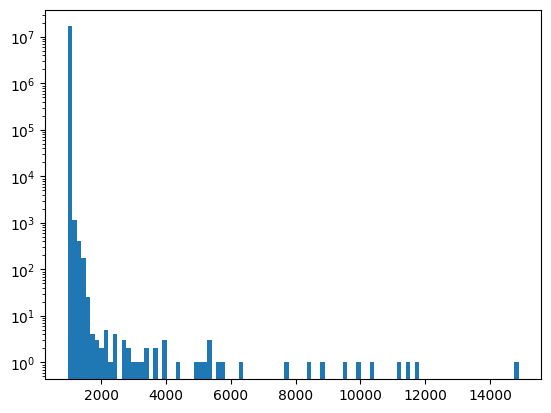

In [14]:
# showing a histogram of pixel values within the FITS file to see how many bright pixels there are, which may help in identifying errors

plt.hist(sample_file.flatten(), bins=100, log=True)
plt.show()

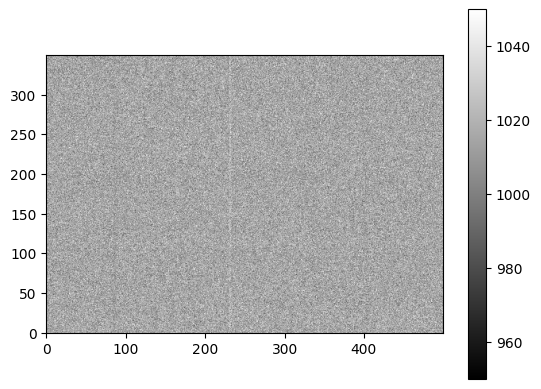

1015.0828857142857


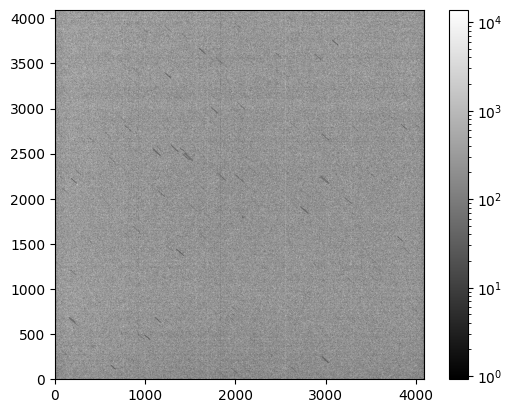

In [15]:
# defining a small region within the image that is all background, for background reduction
section1 = sample_file[0:1000, 1500:2500]
section2 = sample_file[250:600, 1600:2100]

plt.figure()
plt.imshow(section2, origin = 'lower', vmin = 950, vmax=1050, cmap='gray')
plt.colorbar()
plt.show()

background_mean = np.mean(section2)

print(background_mean)

# subtract background

sample_background_subtracted = sample_file - background_mean

# clip negative values to 0 
sample_background_clipped = np.clip(sample_background_subtracted, 0, None)

plt.figure()
# log scaling for high contrast
plt.imshow(sample_background_clipped, origin = 'lower', norm = LogNorm(), cmap='gray')
# plt.imshow(sample_file, origin = 'lower', vmin = 950, vmax=1050, cmap='gray')
plt.colorbar()
plt.show()

In [16]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(sample_background_clipped, sigma=3.0)

print((mean, median, std))

(np.float64(1.4285679929140775), np.float64(0.0), np.float64(2.37122802737859))


In [17]:
from photutils.detection import DAOStarFinder

# want to find sources 200 standard deviations above the background level (alienates the satellite) from other sources
# need a better way to isolate the satellite, maybe just search for a lower threshold then filter by brightness, take the highest
daofind = DAOStarFinder(fwhm = 3.0, threshold=200*std)

sources = daofind(sample_background_clipped - median)

if sources is not None:
    sources.pprint(max_width = 150)

 id     xcentroid         ycentroid           sharpness      ...        peak               flux                mag             daofind_mag    
--- ----------------- ------------------ ------------------- ... ------------------ ------------------ ------------------- -------------------
  1 2083.076546482667 1795.1506432817403 0.49503712131707406 ... 13863.917114285714 143218.92785714284 -12.890001045639982 -3.3042346140148955


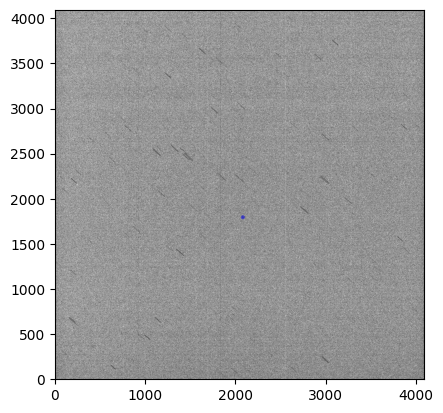

In [18]:
position = np.transpose((sources['xcentroid'], sources['ycentroid'])) # get position of satellite source

aperture = CircularAperture(position, r=10.0) # draw an aperture around the position with a radius of 5 (set to 60 for now to see, but probably want lower for more accurate flux reading)

plt.imshow(sample_background_clipped, origin = 'lower', norm = LogNorm(), cmap='gray')

aperture.plot(color='blue', lw=1.5, alpha=0.5) # alpha = opacity

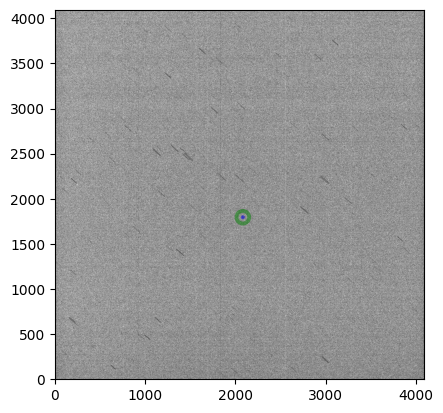

In [19]:
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(position, r_in = 60.0, r_out = 80.0) # inner and outer aperture radius to remove background noise from

plt.figure()
plt.imshow(sample_background_clipped, origin = 'lower', norm = LogNorm(), cmap='gray')
aperture.plot(color='blue', lw=1.5, alpha=0.5) # alpha = opacity
annulus_aperture.plot(color='green', lw=1.5, alpha=0.5)
plt.show()

In [20]:
aperstats = ApertureStats(sample_background_clipped, annulus_aperture)

bkg_mean = aperstats.mean # grabs the mean background value per pixel from the annulus

aperture_area = aperture.area_overlap(sample_background_clipped) # calculates the overlapping area of the circular aperture, i.e. how many pixels are contributing to the star's flux

total_bkg = bkg_mean * aperture_area # estimates the total background contribution within the star aperture, subtracted to isolate the star's actual flux

star_data = aperture_photometry(sample_background_clipped, aperture) # performs aperture photometry, summing all pixel values within the circular apeture (star + background)

star_data['total_bkg'] = total_bkg # adds the computed background flux to the table

star_data.pprint()

 id      xcenter           ycenter          aperture_sum        total_bkg     
--- ----------------- ------------------ ------------------ ------------------
  1 2083.076546482667 1795.1506432817403 191802.76693897505 1150.6594795976084


In [21]:
# from acstools import acszpt

# # get the header of the fits file with: more 'starlink_dataset/20201220013535730_45696.fit'

# # intrument: ProLine PL16803
# # filter: Filter -1
# # date: 2020-12-20T01:35:35.730000
# # EXPOSURE=             0.100000 / exposure time [s]        

# # only works for Hubble Space Telescope cameras, not ground based

# date = '2020-12-20'
# instrument = 'ProLine PL16803'
# filter = 'Filter -1'

# q = acszpt.Query(date = date, detector = instrument)

# zpt_table = q.fetch() 

# q_filter = acszpt.Query(date = date, detector = instrument, filter = filter)

# filter_zpt = q_filter.fetch()

# print(filter_zpt)


In [22]:
# can try determine zero point magnitude by using Vizier query on the RA and DEC in the header files

from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
import astropy.units as u
from astropy.wcs import WCS

# from astropy.coordinates import Angle

# print(header_data['RA'])

# print(header_data['DEC'])

# ra_deg = Angle(header_data['RA'], unit='hourangle').deg

# dec_deg = Angle(header_data['DEC'], unit='deg').deg

# print(ra_deg)

# print(dec_deg)

# create SkyCoord object for the center of the image using RA and DEC from the FITS header
center_coord = SkyCoord(header_data['RA'], header_data['DEC'], unit=(u.hourangle, u.deg), frame='icrs')

radius = 0.1 * u.deg # search radius of 0.1 degrees

Vizier.ROW_LIMIT = 200 # limit number of stars returned

# query the 'II/336/apass9' catalog, good for ground based telescopes
catalog_list = Vizier.query_region(center_coord, radius=radius, catalog='II/336/apass9')

apass_catalog = catalog_list[0] # first table in the list is the APASS catalog

print(apass_catalog)

from astropy.coordinates import match_coordinates_sky

# SkyCoord object for all stars in the APASS region using their RA and DEC columns
catalog_coords = SkyCoord(ra=apass_catalog['RAJ2000'], dec=apass_catalog['DEJ2000'], unit=(u.deg, u.deg))

# find all sources, stars or satellite, that are 5 standard deviations above the background
daofind = DAOStarFinder(fwhm = 3.0, threshold=5*std)
sources = daofind(sample_background_clipped - median)
x_pixels = sources['xcentroid']
y_pixels = sources['ycentroid']

# converts pixel coordinates to world coordinates (RA, DEC) using the WCS information from the FITS header
# THESE IMAGES ARE NOT WCS CALIBRATED, SO THIS WILL NOT GIVE ACCURATE RA AND DEC VALUES
# can try run through astrometry.net to get a calibrated WCS solution
wcs = WCS(header_data)
coords = wcs.pixel_to_world(x_pixels, y_pixels)

print(wcs)

# cross-match detectede sources to catalog stars by position, helps identify which sources are stars and which are not
# returns: idx - closest catalog index for each source, d2d - 2D separation between source and closest catalolog star, d3d - 3D separation
idx, d2d, d3d = match_coordinates_sky(coords, catalog_coords)



 RAJ2000    DEJ2000   e_RAJ2000 e_DEJ2000 ... r'mag  e_r'mag i'mag  e_i'mag
   deg        deg       arcsec    arcsec  ...  mag     mag    mag     mag  
---------- ---------- --------- --------- ... ------ ------- ------ -------
303.886704   7.138431     0.689     0.713 ... 16.469   0.017     --      --
303.903896   7.135727     0.658     0.999 ... 15.366   0.124 15.030   0.058
303.911535   7.155141     0.920     1.010 ... 16.197   0.087 15.821   0.263
303.925781   7.147090     0.366     0.414 ... 14.360   0.102 14.000   0.041
303.928552   7.160637     0.720     0.403 ... 13.167   0.080 13.024   0.056
303.919665   7.158812     1.092     0.986 ... 16.759   0.000     --      --
303.920104   7.158205     0.254     1.322 ... 16.652   0.000     --      --
303.956569   7.156347     0.570     1.220 ... 15.740   0.000     --      --
303.927597   7.179872     0.577     0.651 ... 13.982   0.071 13.716   0.061
       ...        ...       ...       ... ...    ...     ...    ...     ...
303.836338  

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


AttributeError: 'list' object has no attribute 'transform_to'

In [2]:
# checking astrometry.net works

import subprocess

# sample file
fits_path = r"C:\Users\Kevin Chen\Desktop\Uni\Thesis\Thesis-B-Telescope-Imaging\starlink_dataset\20201220013933648_45696.fit"

# Convert Windows path to WSL path
wsl_path = "/mnt/c/Users/Kevin Chen/Desktop/Uni/Thesis/Thesis-B-Telescope-Imaging/starlink_dataset/20201220013933648_45696.fit"

index_path = "/mnt/c/Users/Kevin Chen/Desktop/Uni/Thesis/Thesis-B-Telescope-Imaging/index"


# Run solve-field inside WSL
result = subprocess.run([
    "wsl",
    "solve-field",
    wsl_path,
    "--overwrite",
    "--objs", "200",
    "--sigma", "10",
    "--index-dir", index_path
], capture_output=True, text=True)

print(result.stdout)
print(result.stderr)

This program is part of the Astrometry.net suite.
For details, visit http://astrometry.net.
Git URL https://github.com/dstndstn/astrometry.net
Revision 0.93, date Mon_Dec_19_16:41:15_2022_-0500.

Usage:   solve-field [options]  [<image-file-1> <image-file-2> ...] [<xyls-file-1> <xyls-file-2> ...]

You can specify http:// or https:// or ftp:// URLs instead of filenames.  The "wget" or "curl" program will be used to retrieve the URL.

Options include:
  -h / --help: print this help message
  --version: print version string and exit
  -v / --verbose: be more chatty -- repeat for even more verboseness
  -D / --dir <directory>: place all output files in the specified directory
  -o / --out <base-filename>: name the output files with this base name
  -b / --backend-config <filename>: use this config file for the
          "astrometry-engine" program
  --config <filename>: use this config file for the "astrometry-engine" program
  --batch: run astrometry-engine once, rather than once per inpu

In [ ]:
import math 

exposure_time = 0.1

data = star_data[0]

magnitude = -2.5 * math.log10(abs(data[3] - data[4])/exposure_time)

print(magnitude)

-15.700604025767205


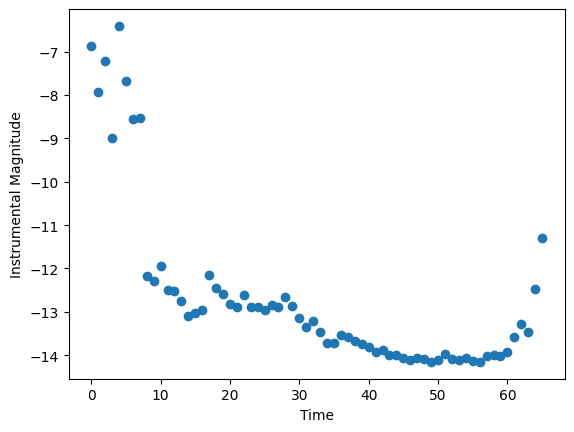

[np.float64(-6.860915606196025), np.float64(-7.917623688039531), np.float64(-7.216475677849893), np.float64(-8.986237683620264), np.float64(-6.403773946404568), np.float64(-7.669700207316987), np.float64(-8.544548150356434), np.float64(-8.523569215459105), np.float64(-12.169521768051514), np.float64(-12.295586173503203), np.float64(-11.943928204516258), np.float64(-12.506753165037148), np.float64(-12.5132294157224), np.float64(-12.741961668651276), np.float64(-13.0935698264729), np.float64(-13.03042190273919), np.float64(-12.962160854249163), np.float64(-12.144068806414538), np.float64(-12.447959262447254), np.float64(-12.592957741919204), np.float64(-12.82756963162186), np.float64(-12.894540117115724), np.float64(-12.618020914982594), np.float64(-12.890001045639982), np.float64(-12.883149029532703), np.float64(-12.947643159503603), np.float64(-12.846971520477478), np.float64(-12.890334556418638), np.float64(-12.665180221206253), np.float64(-12.863239127452573), np.float64(-13.15377528

In [ ]:
star_magnitudes = []

# print(fits_data[30])

# open all fits files, append the image data for each one onto fits_data
for file in fits_data:
    background_subtracted = file - background_mean

    # clip negative values to 0 
    background_clipped = np.clip(background_subtracted, 0, None)

    mean, median, std = sigma_clipped_stats(background_clipped, sigma=3.0)

    # want to find sources 3 standard deviations above the background level
    daofind = DAOStarFinder(fwhm = 3.0, threshold=3*std)

    sources = daofind(background_clipped - median)

    brightest_idx = np.argmin(sources['mag']) if sources is not None else None # index of the brightest source, else return None



    # try not using apperture photometry at first to improve runtime

    # position = np.transpose((sources['xcentroid'], sources['ycentroid'])) # get position of satellite source

    # aperture = CircularAperture(position, r=10.0) # draw an aperture around the position with a radius of 5 (set to 60 for now to see, but probably want lower for more accurate flux reading)

    # annulus_aperture = CircularAnnulus(position, r_in = 60.0, r_out = 80.0) # inner and outer aperture radius to remove background noise from

    # aperstats = ApertureStats(background_clipped, annulus_aperture)

    # bkg_mean = aperstats.mean # grabs the mean background value per pixel from the annulus

    # aperture_area = aperture.area_overlap(background_clipped) # calculates the overlapping area of the circular aperture, i.e. how many pixels are contributing to the star's flux

    # total_bkg = bkg_mean * aperture_area # estimates the total background contribution within the star aperture, subtracted to isolate the star's actual flux

    # star_data = aperture_photometry(background_clipped, aperture) # performs aperture photometry, summing all pixel values within the circular apeture (star + background)

    # star_data['total_bkg'] = total_bkg # adds the computed background flux to the table

    # exposure_time = 0.1

    # data = star_data[0]

    # magnitude = -2.5 * math.log10(abs(data[3] - data[4])/exposure_time)

    if brightest_idx is not None:
        # sources.pprint(max_width = 150)
        
        magnitude = sources['mag'][brightest_idx]

        star_magnitudes.append(magnitude)

plt.plot(star_magnitudes, 'o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Time')
# plt.ylim(-15.705, -15.695)  # y-axis from -15.8 (bottom) to -15.6 (top)
plt.show()

print(star_magnitudes)